# Supplementary code for MA930 Assignment 2

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# built-in statistics functions
from statistics import variance
from scipy.stats import mode

# time series analysis
from statsmodels.tsa import stattools

#plotting
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})

This dataset documents pollution at various sites in the U.S. for four major pollutants. The time scale for most sites is daily data for the years 2000 - 2016. 

In this analysis I will focus on two pollutants: Nitrogen Dioxide (NO2) and Ozone (O3) and one particular site located in Pittsburg, Pennsylvania.

In [2]:
# importing data
cols = [3, 5, 8, 13, 18]
ds = pd.read_csv('./pollution_us_2000_2016.csv', header=0, usecols=cols)

ds

,Site Num,State,Date Local,NO2 AQI,O3 AQI
0,3002,Arizona,2000-01-01,46,34
1,3002,Arizona,2000-01-01,46,34
2,3002,Arizona,2000-01-01,46,34
3,3002,Arizona,2000-01-01,46,34
4,3002,Arizona,2000-01-02,34,27
...,...,...,...,...,...
1746656,100,Wyoming,2016-03-30,1,44
1746657,100,Wyoming,2016-03-31,1,44
1746658,100,Wyoming,2016-03-31,1,44
1746659,100,Wyoming,2016-03-31,1,44


In [3]:
# cleaning data

# selecting station in Pittsburg, Pennsylvania
pitts = ds[(ds['Site Num'] == 3001)]

# removing station no., state columns
pitts = pitts.drop(['Site Num', 'State'], axis=1)

# Delete rows with NaNs
pitts = pitts.dropna(axis='rows')

# Change date from string to date value
pitts['Date Local'] = pd.to_datetime(pitts['Date Local'], format='%Y-%m-%d')

pitts

,Date Local,NO2 AQI,O3 AQI
7848,2000-01-01,25,16
7849,2000-01-01,25,16
7850,2000-01-01,25,16
7851,2000-01-01,25,16
7852,2000-01-02,16,19
...,...,...,...
1735754,2016-03-30,35,48
1735755,2016-03-31,11,45
1735756,2016-03-31,11,45
1735757,2016-03-31,11,45


In [4]:
# count NaNs in AQI index cols (sanity check)
print('NO2: ', pitts['NO2 AQI'].isna().sum())
print('O3: ', pitts['O3 AQI'].isna().sum())

NO2:  0
O3:  0


In [5]:
# extracting the monthly mean AQIs for both pollutants

months = np.arange(1,13)
years = np.arange(2000,2016)
nmonths = int(16*12)

NO2means = np.zeros(nmonths)
O3means = np.zeros(nmonths)

j = 0
for YY in years:
    for MM in months:
        NO2means[j] = pitts['NO2 AQI'][(pitts['Date Local'].dt.month==MM)
                                         & (pitts['Date Local'].dt.year==YY)].mean()
        O3means[j] = pitts['O3 AQI'][(pitts['Date Local'].dt.month==MM)
                                         & (pitts['Date Local'].dt.year==YY)].mean()
        
        j += 1

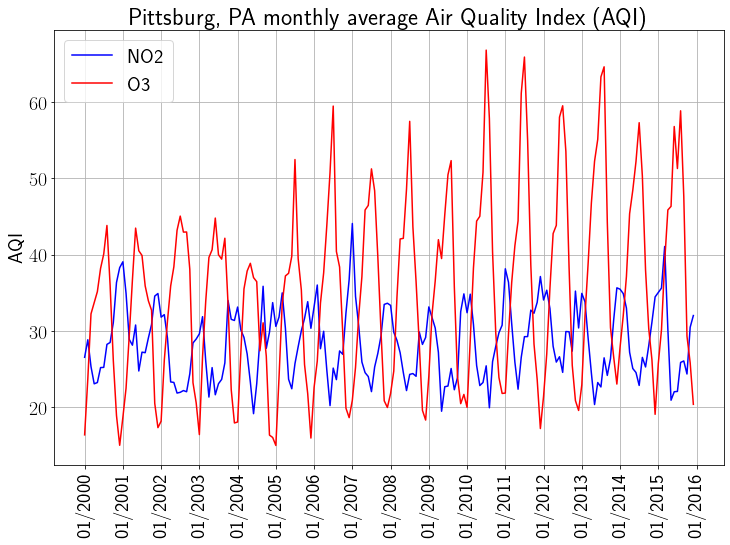

In [6]:
t = ['01/2000', '01/2001', '01/2002', '01/2003', '01/2004', '01/2005', '01/2006', '01/2007', '01/2008',
     '01/2009', '01/2010', '01/2011', '01/2012', '01/2013', '01/2014', '01/2015', '01/2016']

# plotting
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(range(nmonths), NO2means, 'b', label='NO2')
ax.plot(range(nmonths), O3means, 'r', label='O3')
ax.set_ylabel('AQI')
ax.legend(loc='upper left')
ax.set_xticks(np.arange(0,nmonths+12,12))
ax.set_xticklabels(t,rotation='vertical')
ax.set_title('Pittsburg, PA monthly average Air Quality Index (AQI)')
ax.grid()

**Ideas**
1. Propose sinusoidal model for signal, autoregressive model for noise
2. Bayesian inference (ABC) for parameters
3. Credible interval

OR (if all else fails)

1. Fit gamma distribution to summer and winter months
2. Covariance and correlation of time series
3. Hypothesis test (chi-squared against proposed Gamma distribution)

Series = sinusoidal deterministic part + noise?

Model noise first

From plotting the monthly means we can see there is a clear seasonal effect to the time series. Comparing the two empirical distributions below, we can see that the air quality indexes for O3 and NO2 are consistently higher in the summer and winter respectively.

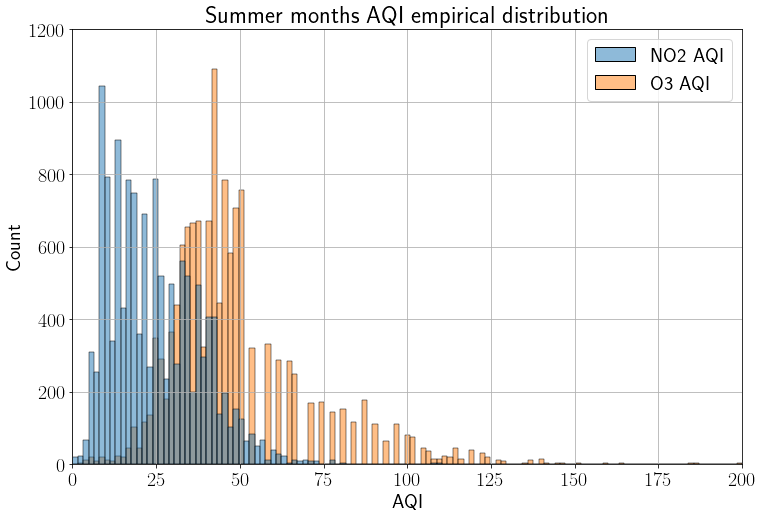

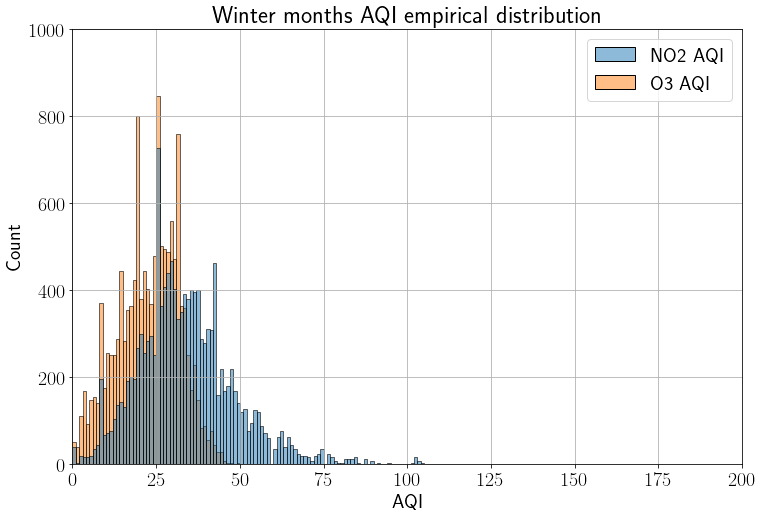

In [7]:
# Empirical distribution for summer monthly means
summer = pitts[(pitts['Date Local'].dt.month>5)&(pitts['Date Local'].dt.month<9)]

plt.figure(figsize=(12,8))
sns.histplot(summer)
plt.xlim([0,200])
plt.ylim([0,1200])
plt.xlabel('AQI')
plt.title('Summer months AQI empirical distribution')
plt.grid()

# Empirical distribution for winter monthly means
winter = pitts[(pitts['Date Local'].dt.month>11)|(pitts['Date Local'].dt.month<3)]

plt.figure(figsize=(12,8))
sns.histplot(winter)
plt.xlim([0,200])
plt.ylim([0,1000])
plt.xlabel('AQI')
plt.title('Winter months AQI empirical distribution')
plt.grid()

The autocovariance for both pollutants is of sinusoidal form, suggesting we should suggest a sinusoidal model for the signal and an autoregressive model for the noise

In [8]:
autocovNO2 = stattools.acovf(NO2means)
autocovO3 = stattools.acovf(O3means)

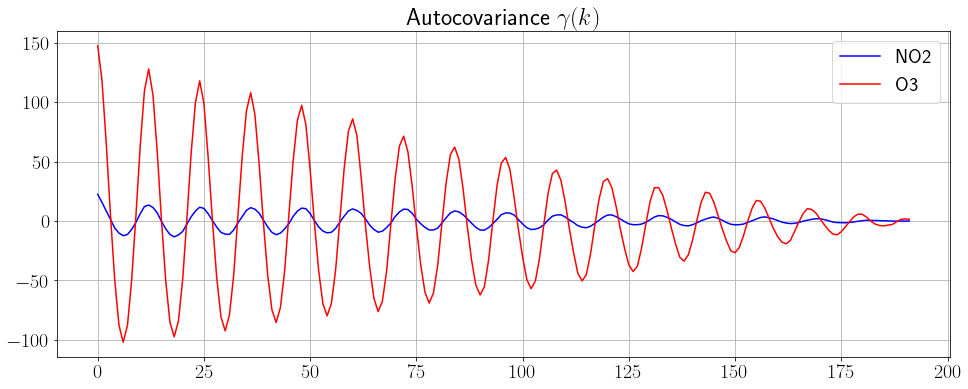

In [9]:
fig = plt.figure(figsize=(16,6))
plt.plot(range(nmonths), autocovNO2, 'b', label='NO2')
plt.plot(range(nmonths), autocovO3, 'r', label='O3')
plt.legend(loc=0)
plt.title('Autocovariance $\gamma (k)$')
plt.grid()

For NO2 we propose a model

$$Y_t = S_t + W_t$$

where $t$ is measured in months from January 2000, $S_t$ represents the signal component

$$S_t = a - A \sin(w t + e)$$

and $W_t$ is an autoregressive model of order 1 representing stochastic noise

$$W_t = \phi_1 W_{t-1} + \epsilon_t$$

In [10]:
# smoothing data
def boxcar_smooth(arr, n):
    newarr = []
    for i in range(n,len(arr)-n):
        newarr += [np.sum(arr[i-n:i+n])/(2*n+1)]
    
    return np.array(newarr)

n = 1
O3means_smooth = boxcar_smooth(O3means, n)
NO2means_smooth = boxcar_smooth(NO2means, n)

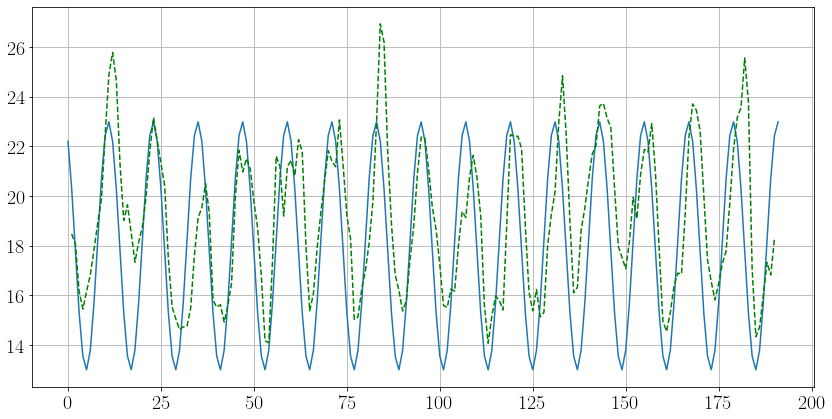

In [11]:
ts = np.arange(0, nmonths)

# signal function
def signal(a, A, w, e, ts):
    return a - A*np.sin(w*ts + e)

# comparison with sample signal with a = 18, A = 5, w = 2pi/12, e = -1
fig = plt.figure(figsize=(14,7))

plt.plot(ts, signal(18, 5, 2*np.pi/12, -1, ts))
#plt.plot(range(n,nmonths-n), O3means_smooth, '--r', label='O3')
plt.plot(range(n,nmonths-n), NO2means_smooth, '--g', label='NO2')
plt.grid()

In [12]:
# if the AQI is seasonal with period 12 months, we make our analysis easier by approximating the period
w = 2*np.pi/12

# cost function
def C(a, A, e):
    cost = 0
    for i in range(n,nmonths-n):
        cost += (signal(a, A, w, e, ts[i]) - NO2means_smooth[i-n])**2
    
    return 0.5*cost

# gradient
def gradC(a, A, e):
    cost = np.zeros(3)
    for i in range(n,nmonths-n):
        dcost = signal(a, A, w, e, ts[i]) - NO2means_smooth[i-n]
        cost[0] += dcost
        cost[1] += dcost*(-np.sin(w*ts[i] + e))
        cost[2] += dcost*(-A*np.cos(w*ts[i] + e))
    
    return cost

In [13]:
def gradient_descent(f, df, init, alpha, updates, track_guesses=False):
    # basic three-parameter gradient descent algorithm with fixed update rule, taking parameters:
    # f: function to be minimised
    # df: gradient of f
    # alpha: update rule
    # updates: number of iterations to run algorithm
    # track_guess: if true we will keep track of the set of parameters and cost function
    # evaluation at each iteration
    
    current = init
    guesses = np.hstack(( init, C(current[0], current[1], current[2]) ))

    for i in range(updates):
        # method of steepest descent
        current -= alpha*df(current[0], current[1], current[2])
        
        if track_guesses == True:
            guesses = np.vstack(( guesses, np.hstack(( current, C(current[0], current[1], current[2]) )) ))
        
    if track_guesses == True:
        return guesses
    
    else:
        return current

257.1508215781863


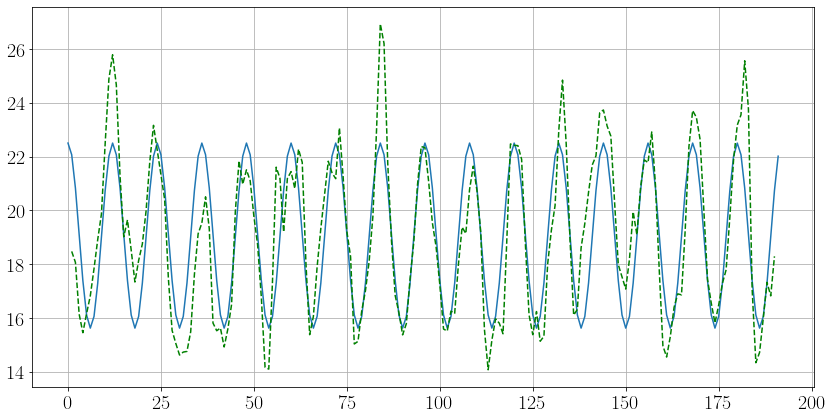

In [14]:
# performing gradient descent from initial conditions:
# a = 18, A = 5, e = -1
# with update rule alpha = 0.0001 for 2000 iterations
[atrial, Atrial, etrial, Ctrial] = gradient_descent(C, gradC, [18, 5, -1], 0.0001, 2000, track_guesses=True)[-1,:]
print(Ctrial)

# plotting
fig = plt.figure(figsize=(14,7))
plt.plot(ts, signal(atrial, Atrial, w, etrial, ts))
#plt.plot(range(n,nmonths-n), O3means_smooth, '--r', label='O3')
plt.plot(range(n,nmonths-n), NO2means_smooth, '--g', label='NO2')
plt.grid()

The second part of the analysis uses Approximate Bayesian Computation (ABC) to infer an approximate likelihood for $\phi_1$ in the noise component of the model

In [15]:
# defining function for model Y_t = S_t + W_t
def model(phi1, ts):
    # signal
    S = signal(atrial, Atrial, w, etrial, ts)
    Y = np.zeros(len(S),dtype='float64')
    
    # initial noise
    W = 0
    Y[0] = S[0] + W
    for j in range(1,len(ts)):
        # update noise at each step
        eps = np.random.normal(0, 0.05)
        W = phi1*W + eps
        Y[j] = S[j] + W
        
    return Y

# chi-squared criterion to measure performance of model against data
def chisq_criterion(simdata, realdata):
    measure = 0
    
    for i in range(len(realdata)):
        measure += (simdata[i] - realdata[i])**2/realdata[i]
    
    return measure

In [16]:
# obtaining approximate measures of criterion to quantify a valid guess
tsmooth = ts[1:-1]
chisq_criterion(model(0.9, tsmooth), NO2means_smooth)

27.274288998836855

j =  0
j =  200
j =  400
j =  600
j =  800
j =  1000
j =  1200
j =  1400
j =  1600
j =  1800
j =  2000
j =  2200
j =  2400
j =  2600
j =  2800
j =  3000
j =  3200
j =  3400
j =  3600
j =  3800
j =  4000
j =  4200
j =  4400
j =  4600
j =  4800
j =  5000
j =  5200
j =  5400
j =  5600
j =  5800
j =  6000
j =  6200
j =  6400
j =  6600
j =  6800
j =  7000
j =  7200
j =  7400
j =  7600
j =  7800
j =  8000
j =  8200
j =  8400
j =  8600
j =  8800
j =  9000
j =  9200
j =  9400
j =  9600
j =  9800
j =  10000
j =  10200
j =  10400
j =  10600
j =  10800
j =  11000
j =  11200
j =  11400
j =  11600
j =  11800
j =  12000
j =  12200
j =  12400
j =  12600
j =  12800
j =  13000
j =  13200
j =  13400
j =  13600
j =  13800
j =  14000
j =  14200
j =  14400
j =  14600
j =  14800
j =  15000
j =  15200
j =  15400
j =  15600
j =  15800
j =  16000
j =  16200
j =  16400
j =  16600
j =  16800
j =  17000
j =  17200
j =  17400
j =  17600
j =  17800
j =  18000
j =  18200
j =  18400
j =  18600
j =  18800
j =  19000
j

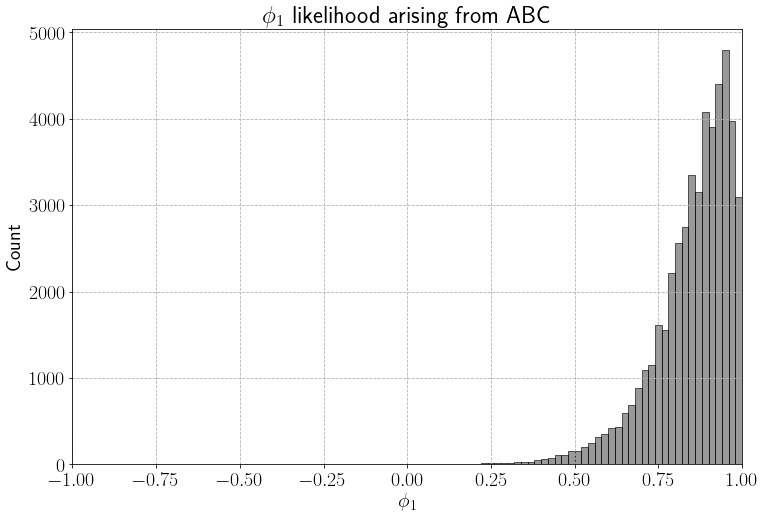

In [17]:
# Approximate Bayesian Computation
# 20,000 random samples of phi_1 each used 150 times to simulate model and perform criterion test
# == 3 million iterations
# ABC algorithm takes ~50s to perform 100,000 iterations

ABC = 20000
Nsim = 150
tol = 26
valid_sims = []

for j in range(ABC):
    # track progress
    if (j%200 == 0):
        print('j = ', j)
    
    # trial phi_1 drawn from uniform distribution
    phitrial = np.random.uniform(-1, 1)

    for sims in range(Nsim):
        if chisq_criterion(model(phitrial, tsmooth), NO2means_smooth) < tol:
            valid_sims += [phitrial]

phidist = np.array(valid_sims)
print(len(valid_sims))

# plotting
fig = plt.figure(figsize=(12,8))
bins = np.arange(-1.00, 1.02, 0.02)

sns.histplot(valid_sims, bins=bins, color='k', alpha=0.4)
plt.xlabel('$\phi_1$')
plt.ylabel('Count')
plt.xlim([-1,1])
plt.title('$\phi_1$ likelihood arising from ABC')
plt.grid(linestyle='--')

In [18]:
# retrieving mode of phi_1 distribution
print('Mode: ', mode(phidist))
phimode = mode(phidist)[0]

Mode:  ModeResult(mode=array([0.96045624]), count=array([39]))


In [19]:
# new cost function
def C2(phi1):
    Y = model(phi1, tsmooth)
    cost = 0
    for i in range(len(tsmooth)):
        cost += (Y[i] - NO2means_smooth[i])**2
    
    return 0.5*cost

C2(phimode)

265.7564282482044

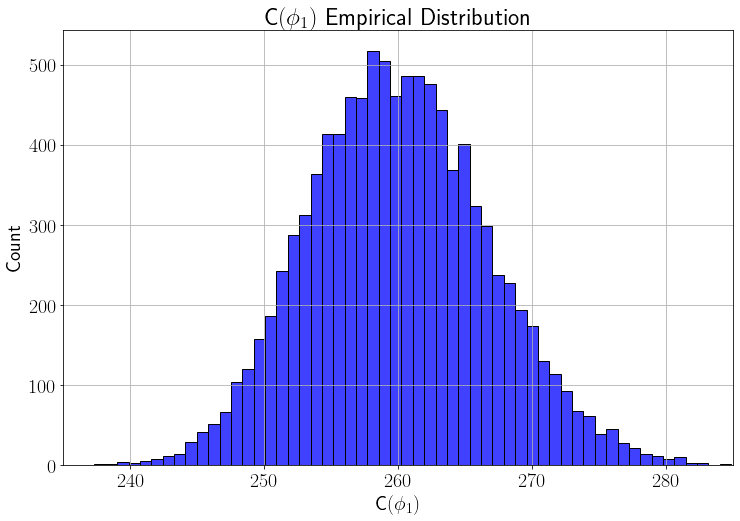

In [22]:
# computing the cost function numerous times for the mode of phi_1 distribution
# and obtaining a ditribution of the cost function
costdist = []
count = 10000
for i in range(count):
    costdist += [C2(phimode)]

fig = plt.figure(figsize=(12,8))

sns.histplot(np.array(costdist), color='b')
plt.xlabel('C$(\phi_1)$')
plt.ylabel('Count')
plt.xlim([235,285])
plt.title('C$(\phi_1)$ Empirical Distribution')
plt.grid()

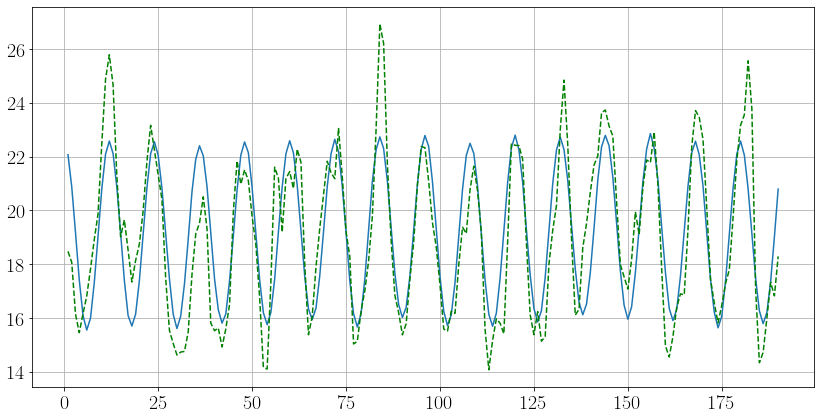

In [23]:
# plotting
fig = plt.figure(figsize=(14,7))
plt.plot(tsmooth, model(phimode, tsmooth))
#plt.plot(range(n,nmonths-n), O3means_smooth, '--r', label='O3')
plt.plot(tsmooth, NO2means_smooth, '--g', label='NO2')
plt.grid()